In [1]:
import networkx as nx
from cgsmiles import read_cgsmiles
import itertools
import numpy as np
from collections import Counter, defaultdict
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import pysmiles
import cgsmiles
import optuna

/local/user/seutelf/anaconda3/envs/log_p_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_inter_matrix(datafile="levels.dat"):
    with open(datafile, 'r') as _file:
        lines = _file.readlines()
        level_dict = {}
        col_labels = lines[0].strip().split() 
        bead_to_index = dict(zip(col_labels, np.arange(0, len(col_labels))))
        for line in lines[1:]:
            tokens = line.strip().split()
            row_type = tokens[-1]
            for idx, token in enumerate(tokens[:-1]):
                level_dict[frozenset([row_type, col_labels[idx]])] = int(token)
    return level_dict, bead_to_index

def read_mol_strings(datafile='mols.dat'):
    mol_strings = {}
    with open(datafile, 'r') as _file:
        lines = _file.readlines()
    for line in lines:
        tokens = line.strip().split()
        mol_strings[tokens[0]] = tokens[1]
    return mol_strings

def modify_level(level, ba, bb, alA, alB, dlA, dlB, rlA, rlB, hlA, hlB):
    
    if ba == 'W' and (alB or dlB):
        level += 1
        
    if bb == 'W' and (alA or dlA):
        level += 1
    
    if alA and alB:
        level += 1
            
    if dlA and dlB:
        level += 1
        
    if (alA and dlB) or (dlA and alB):
        level -= 1
            
    if rlA and rlB:
        level += 1
            
    if hlA and hlB:
        level -= 1
            
    return level


def generate_feature_vector(mol_str_a, mol_str_b, bead_matrix, bead_to_index, polyA=False, polyB=False):
    """
    Generate the graph of a Martini molecule and
    assing bead types.
    """
    feat_level_matrix_W = np.zeros((19, 6),dtype=float)
    feat_level_matrix_SOL = np.zeros((19, 6),dtype=float)
    feat_bead_count_vector = np.zeros((1), dtype=float)
    size_to_plane = {frozenset((0, 0)): 0,
                     frozenset((1, 1)): 1,
                     frozenset((2, 2)): 2,
                     frozenset((0, 1)): 3,
                     frozenset((0, 2)): 4,
                     frozenset((1, 2)): 5,}

    # print(mol_str_a)
    #mol_a = read_cgsmiles(mol_str_a)
    try:
        mol_a, aa_mol = cgsmiles.resolve.MoleculeResolver.from_string(mol_str_a, legacy=True).resolve_all()
    except:
        print(mol_str_a)
        raise
    smiles_str = pysmiles.write_smiles(aa_mol)
   # print(smiles_str)
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles_str))
    AllChem.EmbedMolecule(mol)
    vol = AllChem.ComputeMolVolume(mol)
    
    mol_b = read_cgsmiles(mol_str_b)
   # print(mol_str_a, mol_str_b)
    mol_a_types = list(nx.get_node_attributes(mol_a, "fragname").values())
    mol_b_types = list(nx.get_node_attributes(mol_b, "fragname").values())
    feat_bead_count_vector = vol #len(mol_a_types)
    #print(mol_a_types)
   # print(mol_b_types)
    inter_graphs = []
    for mol in [mol_a_types, mol_b_types, ['W']]:
       # print(mol)
        inter_graph = nx.Graph()
        idx = 0
        #bead_counts = Counter(mol)
        #Efor bead, num in bead_counts.items():
        for bead in mol:
            if bead[0] == "T":
                size = 0
                bead = bead[1:]
            elif bead[0] == "S":
                size = 1
                bead = bead[1:]
            else:
                size = 2 
                        
            al = False
            dl = False
            hl = False
            rl = False
            el = False
            vl = False
            
            if bead[-1].isupper() and bead[-1] != 'W':
                bead = bead[:-1]
            
            if bead[-1] == "r":
                rl = True
                bead = bead[:-1]
            
            if bead[-1] == "h":
                hl = True
                bead = bead[:-1]
            
            if bead[-1] == 'e':
                el = True
                bead = bead[:-1]
            
            if bead[-1] == 'v':
                vl = True
                bead = bead[:-1]
        
            if bead[-1] == "a":
                al = True
                bead = bead[:-1]

            if bead[-1] == "d":
                dl = True
                bead = bead[:-1]

        
            bead_index = bead_to_index[bead]        
            inter_graph.add_node(idx, size=size, bead_type=bead, alabel=al, dlabel=dl, rlabel=rl, hlabel=hl)
            idx += 1
        inter_graphs.append(inter_graph)
    #print(len(inter_graphs))
   # print(inter_graphs[0].nodes(data=True))
        
    # combinations of W with solute
    # combinations of solvent and solute
    bead_combos = []
    counter = 0
    for inter_graph_a, inter_graph_b in [(inter_graphs[0],inter_graphs[1]), (inter_graphs[0], inter_graphs[2])]:
       # print(inter_graph_a.nodes(data=True))
       # print(inter_graph_b.nodes(data=True))
       # print("\n")
        bead_combos = itertools.product(inter_graph_a.nodes, inter_graph_b.nodes)
        #print(list(bead_combos))
        bead_combos = itertools.product(inter_graph_a.nodes, inter_graph_b.nodes)
        for ba, bb in bead_combos:
            bead_a = inter_graph_a.nodes[ba]['bead_type']
            bead_b = inter_graph_b.nodes[bb]['bead_type']
            level = bead_matrix[frozenset([bead_a, bead_b])]
            #if level in [3,4,5,6,7,8]:
            #    print(bead_a, bead_b, level)
            level = modify_level(level=level,
                                 ba=bead_a,
                                 bb=bead_b,
                                 alA=inter_graph_a.nodes[ba]['alabel'], 
                                 alB=inter_graph_b.nodes[bb]['alabel'], 
                                 dlA=inter_graph_a.nodes[ba]['dlabel'], 
                                 dlB=inter_graph_b.nodes[bb]['dlabel'], 
                                 rlA=inter_graph_a.nodes[ba]['rlabel'], 
                                 rlB=inter_graph_b.nodes[bb]['rlabel'], 
                                 hlA=inter_graph_a.nodes[ba]['hlabel'], 
                                 hlB=inter_graph_b.nodes[bb]['hlabel'],)
            #print(bead_a, bead_b, level)
            third_dimension = size_to_plane[frozenset([inter_graph_a.nodes[ba]['size'], 
                                                       inter_graph_b.nodes[bb]['size']])]
        
            if counter == 0:
                feat_level_matrix_SOL[level-1, third_dimension] += 1
            else:
                feat_level_matrix_W[level-1, third_dimension] += 1

        counter += 1
       # if polyA:
       #     feat_bead_count_vector[-2] = 1
       # if polyB:
       #     feat_bead_count_vector[-1] = 1
            
        
            
    #feat_level_matrix = np.sum(feat_level_matrix, axis=2)
   # print(feat_level_matrix.shape)
    #print(feat_level_matrix.shape)
    feature_vector = feat_level_matrix_SOL.reshape(-1)
    #print(feature_vector.shape)
    feature_vector = np.hstack([feat_level_matrix_SOL.reshape(-1), 
                                feat_level_matrix_W.reshape(-1)])
    #print(feature_vector.shape)
    #print(feat_bead_count_vector.shape)
    feature_vector = np.hstack([feature_vector, np.array([feat_bead_count_vector])])
    
    return feature_vector, bead_to_index

# Split by solvents

In [3]:
from sklearn.model_selection import train_test_split

m3_df = pd.read_csv('../data/all_logP_v5.csv')

#X = m3_df.drop(columns=["mol_tag"])
#y = m3_df["mol_tag"]

#df_train, df_test, mols_train, mols_test = train_test_split(X, y, test_size=0.15, random_state=3333)


In [4]:
# train_mols = np.array(['W', 'butene', 'propene', 'ethene', 'butyne', 'propyne', '1-propanol', '2-propanol', 'ethanol', 'methanol', 'isobutanal', 'propanal', 'ethanal', 'butane', '2-methylpropane', '2-methyl-propane', 'propane', 'cyclopropane', 'ethane', 'DMFD', 'propanamide', 'acetamide', 'formamide', 'propanoic', 'acetic', 'buta-1,3-diene', 'prop-2-en-1-ol', 'methyl acetate', 'methyl formate', '1-chloropropane', 'TCM', 'bromopropane', 'iodoethane', 'trichloromethane', '1,1-dichloroethane', 'DCE', 'chloroethane', 'dichloromethane', 'bromoethane', 'iodomethane', 'chloromethane', 'bromomethane', 'butanone', 'propanone', 'acetonitrile', 'propane-1-thiol', 'dimethyl-sulfide', 'n-propylamine', 'ethylamine', 'methylamine', 'dimethylamine', 'trimethylamine', 'glycine', 'HXY', 'OCY', 'OCO', 'HPO', 'HXA', 'HPAL', 'BTA', 'CHEX', 'HEX', 'HXE', 'HXD14', 'ETA', 'NBA', 'TBA', 'THP', 'DIOX', 'DXE', 'HXN', 'HPN', 'DMSO', 'PTI', 'HXI', 'HPI', 'BTI', 'HD', 'HXY', 'OCY', 'HXD14', 'TCE', 'IPO', 'ETH', 'NDI', 'DMAD', 'methylhydrazine', 'dibromomethane', 'chlorobromomethane', 'propane', 'difluoromethane', 'diiodomethane', '355120-85-3', 'methoxymethane', 'carbondioxide', 'cyanamide', 'propa-1,2-diene', 'bromoethene', 'chlorofluoromethane', 'cyanamide', 'vinylchloride', 'MAC', 'PVA2', 'MMAC', 'PEG2', 'STYR', 'MAMD', 'PVA', 'AAC', 'MEH', '2VP', '4VP', 'ALA', 'MKA', '12BD', 'R9', 'R25', 'R27', 'R29', 'R11', 'R13', 'R1', 'R23', 'R31', 'R33', 'R204', 'R18', '1MIMI', '2MPYR', '3HT', '3PT', '4MIMI', '4NIAN', 'ACPH', 'BEAL', 'BENZ', 'BRA', 'BZDOL', 'BZQU', 'BZTF', 'CHEX', 'CHEXE', 'CPR', 'CYPO', 'CYPOL', 'DBRBZ', 'DCLBZ', 'DIOX', 'DMAN', 'DMBZQ', 'DXLA', 'IMID', 'IOBZ', 'IOPHE', 'MCYPE', 'CHEX', 'NAPH', 'NIBZ', 'OMA', 'OXYLE', 'PBEN', 'PCYM', 'PHEN', 'PXYLE', 'PYAZ', 'PYLI', 'PYRI', 'PYRR', 'STYR', 'TCLBZ', 'THIO', 'THP', 'THPH', 'THT', 'TOLU', 'XBZ', 'GLC', 'GAL', 'GLA', 'LFUC', 'XYL', 'INO', 'TREH', 'LAC', 'RIBF', 'RN/RP', 'PI/PP', 'NE/NP', 'TN/TP', 'Double_ester_branched', 'CA/CP', 'SC1_ester_SC1', 'C4h_ester_C4h', 'Double_ester_long', 'Z1/ZP', 'DT/DP', 'C1_ester_C1', 'EA/EP', 'AE/AP', 'B1/BP', 'K2/KP', 'M3/MP', 'Ether_link_sat', 'FN/FP', 'Ester_branched3', 'ES/EP', 'Ester_branched_long_sat', 'unknown_251', 'unknown_252', 'unknown_253', 'unknown_254', 'unknown_255', 'unknown_256', 'unknown_257', 'unknown_259', 'unknown_260', 'unknown_261', 'unknown_262', 'unknown_263', 'unknown_264', 'unknown_265', 'unknown_267', 'unknown_268', 'unknown_269', 'unknown_271', 'unknown_272', 'unknown_273', 'unknown_274', 'unknown_277', 'unknown_278', 'unknown_279', 'unknown_280', 'unknown_281', 'unknown_282', 'unknown_283', 'unknown_284', 'unknown_285', 'unknown_286', 'unknown_290', 'unknown_291', 'unknown_294', 'unknown_295', 'unknown_296', 'unknown_297'])
# test_mols = np.array(['HXY', 'OCY', 'CHEX', 'OCE', 'IBA', 'DISH', 'DISS', 'DOD', 'HXY', 'OCY', 'TXE', 'AAMD', 'R202', '2NITL', 'BZNI', 'CHEX', 'CLBZ', 'CUME', 'CYPE', 'EBEN', 'FURA', 'CHEX', 'MXYLE', 'PCRE', 'LRHA', 'FRUF', 'DMG', 'unknown_258', 'unknown_275', 'unknown_288', 'unknown_289', 'unknown_293', 'unknown_298', 'unknown_299', 'unknown_300'])
# val_mols = np.array(['HXO', 'BTO', 'OCT', 'TFEOL', 'ANN', 'OCI', 'DOE', 'STYR', 'PP', '2NIMX', 'ANIL', 'BRBZ', 'MBZOA', 'PBZOA', 'PIPER', 'STYR', 'THAZ', 'THF', 'MAN', 'GYN', 'NMC', 'SUCR', 'ALC', 'S1/SP', 'Ether_link_unsat', 'Ester_branched_long_unsat', 'unknown_266', 'unknown_270', 'unknown_276', 'unknown_287', 'unknown_292'])


import json

ckpt_dir = '../exported_ckpts/new-split-paper'

with open(ckpt_dir + '/train_mol_tags.json', 'r') as f:
    train_mols = json.load(f)

with open(ckpt_dir + '/test_mol_tags.json', 'r') as f:
    test_mols = json.load(f)

with open(ckpt_dir + '/val_mol_tags.json', 'r') as f:
    val_mols = json.load(f)


# THERE IS AN ERR WITH JSON SAVING, HARD CODE INSTEAD:
################

# train_tags = ['{[#W]}.{#W=O}', '{[#C4]}.{#C4=CCC=C}', '{[#SC4]}.{#SC4=CC=C}', '{[#TC4]}.{#TC4=C=C}', '{[#C6]}.{#C6=CCC#C}', '{[#SC6]}.{#SC6=CC#C}', '{[#P1]}.{#P1=CCCO}', '{[#SN6]}.{#SN6=CC(C)O}', '{[#SP1]}.{#SP1=CCO}', '{[#SP2r]}.{#SP2r=CO}', '{[#N4a]}.{#N4a=CC(C)C=O}', '{[#N5a]}.{#N5a=CCC=O}', '{[#SN5a]}.{#SN5a=CC=O}', '{[#C1]}.{#C1=CCCC}', '{[#C2]}.{#C2=CC(C)C}', '{[#SC1]}.{#SC1=CC(C)C}', '{[#SC2]}.{#SC2=CCC}', '{[#SC3]}.{#SC3=C1CC1}', '{[#TC2]}.{#TC2=CC}', '{[#P3a]}.{#P3a=CN(C)C=O}', '{[#P5]}.{#P5=CCC(N)=O}', '{[#SP5]}.{#SP5=CC(N)=O}', '{[#SP6r]}.{#SP6r=NC=O}', '{[#P2]}.{#P2=CCC(O)=O}', '{[#SP2]}.{#SP2=CC(O)=O}', '{[#C5]}.{#C5=C=CC=C}', '{[#P1]}.{#P1=OCC=C}', '{[#N4]}.{#N4=COC(C)=O}', '{[#SN4]}.{#SN4=COC=O}', '{[#X3]}.{#X3=CCCCl}', '{[#X1]}.{#X1=C(Cl)(Cl)(Cl)(Cl)}', '{[#X1]}.{#X1=CCCBr}', '{[#X1]}.{#X1=CCI}', '{[#X2]}.{#X2=ClC(Cl)Cl}', '{[#X3h]}.{#X3h=CC(Cl)Cl}', '{[#X4h]}.{#X4h=ClCCCl}', '{[#SX3]}.{#SX3=CCCl}', '{[#SX2]}.{#SX2=ClCCl}', '{[#SX1r]}.{#SX1r=CCBr}', '{[#SX1]}.{#SX1=CI}', '{[#TX3]}.{#TX3=CCl}', '{[#TX2]}.{#TX2=CBr}', '{[#N4a]}.{#N4a=CCC(C)=O}', '{[#SN5a]}.{#SN5a=CC(C)=O}', '{[#SN5ah]}.{#SN5ah=CC#N}', '{[#C6]}.{#C6=CCCS}', '{[#SC6]}.{#SC6=CSC}', '{[#N6d]}.{#N6d=CCCN}', '{[#SN6d]}.{#SN6d=CCN}', '{[#TN6d]}.{#TN6d=CN}', '{[#SN3]}.{#SN3=CNC}', '{[#SN3a]}.{#SN3a=CN(C)C}', '{[#P6]}.{#P6=NCC(O)=O}', '{[#C1][#C6]}.{#C1=CCCC[$],#C6=[$]CCC#C}', '{[#SC2][#SC2][#SP1]}.{#SC2=[$]CCC[$],#SP1=[$]CCO}', '{[#C1][#SP1]}.{#C1=CCCC[$],#SP1=[$]CCO}', '{[#TC2][#SP1]}.{#TC2=CC[$],#SP1=[$]CCO}', '{[#C1][#N6a]}.{#C1=CCCC[$],#N6a=[$]CCC=O}', '{[#TC3][#SN6a]}.{#TC3=CC[$],#SN6a=[$]CC=O}', '{[#SC3]=[#SC3]}.{#SC3=[$]CCC[$]}', '{[#SC2][#SC2]}.{#SC2=CCC[$]}', '{[#C1][#C1]}.{#C1=[$]CCCC}', '{[#SC2][#SC4]}.{#SC2=CCC[$],#SC4=[$]CC=C}', '{[#C1][#C4h]}.{#C1=CCCC[$],#C4h=[$]CCC=C}', '{[#C2][#SN4a]}.{#C2=CCCC[$],#SN4a=[$]OC(C)=O}', '{[#SC2][#SN4a]}.{#SC2=[$]C(C)(C)(C),#SN4a=[$]OC(C)=O}', '{[#SC3]=[#SN4a]}.{#SC3=[$]CCC[$],$SN4a=[$]COC[$]}', '{[#SN3a]=[#SN3a]}.{#SN3a=[$]COC[$]}', '{[#SN3r][#SN3r]}.{#SN3r=[$]COC[$]}', '{[#C2][#SN6a]}.{#C2=CCCC[$],#SN6a=[$]C(=O)C}', '{[#C2][#N6a]}.{#C2=CCCC[$],#N6a=[$]CC(=O)C}', '{[#SN5a][#SN5a]}.{#SN5a=CC(=O)C[!]}', '{[#TC3][#SC5][#TC3]}.{#TC3=CC[!]C,#SC5=[!]CSC[!]}', '{[#SC6][#TP6]}.{#SC6=CS[!]C,#TP6=[!]S=O}', '{[#SC2][#SN6d]}.{#SC2=CCC[$],#SN6d=[$]CCN}', '{[#C1][#SN6d]}.{#C1=CCCC[$],#SN6d=[$]CCN}', '{[#C1][#N6d]}.{#C1=CCCC[$],#N6d=[$]CCCN}', '{[#SC2][#SC2][#SN6d]}.{#SC2=[<]CCC[>],#SN6d=[>]CCN}', '{[#TC2][#SN6d]}.{#TC2=CC[$],#SN6d=[$]CCN}', '{[#C1]|3}.{#C1=[$]CCCC[$]}', '{[#SC6][#SC2]}.{#SC6=C#CC[$],#SC2=CCC[$]}', '{[#C6][#C1]}.{#C1=[$]CCCC,#C6=[$]CCC#C}', '{[#SC4]|2}.{#SC4=[<]C=CC[>]}', '{[#X3h]}.{#X3h=ClC=C(Cl)Cl}', '{[#P1]}.{#P1=CC(C)O}', '{[#N2]}.{#N2=CCOCC}', '{[#SN3]}.{#SN3=CCN(C)C}', '{[#P2h]}.{#P2h=CN(C)C(C)=O}', '{[#P5d]}.{#P5d=CNN}', '{[#SX1]}.{#SX1=BrCBr}', '{[#SX2]}.{#SX2=ClCBr}', '{[#SC1]}.{#SC1=CCC}', '{[#TX4]}.{#TX4=FCF}', '{[#X2]}.{#X2=ICI}', '{[#C6]}.{#C6=S=C=S}', '{[#SN3a]}.{#SN3a=COC}', '{[#SC6]}.{#SC6=O=C=O}', '{[#P4d]}.{#P4d=NC#N}', '{[#SC4]}.{#SC4=C=C=C}', '{[#SX1]}.{#SX1=BrC=C}', '{[#SX4]}.{#SX4=FCCl}', '{[#SN6]}.{#SN6=NC#N}', '{[#SX3]}.{#SX3=ClC=C}', '{[#TC3][#TP6a]}.{#TC3=CC[$],#TP6a=[$]C(=O)N}', '{[#SN6r]|2}.{#SN6r=[<]CC[>](O)}', '{[#SC3][#SN4a]}.{#SC3=CC[$](C),#SN4a=[$]C(=O)OC}', '{[#SN3r]|2}.{#SN3r=[$]COC[$]}', '{[#TC3][#TC5]1[#TC5][#TC5]1}.{#TC3=CC[<],#TC5=[>][>]cc[<]}', '{[#SC3][#TP6a]}.{#SC3=CC(C)[$],#TP6a=[$]C(=O)N}', '{[#SN6r]}.{#SN6r=CCO}', '{[#TC3][#TP2a]}.{#TC3=CC[$],#TP2a=[$]C(=O)O}', '{[#SN3r]}.{#SN3r=COC}', '{[#TC3][#TN6a]1[#TC5][#TC5]1}.{#TC3=CC[$],#TC5=[>]cc[<],#TN6a=[$][>]cn[<]}', '{[#TC3][#TC5]1[#TC5][#TN6a]1}.{#TC3=CC[$],#TC5=[$][>]cc[<],#TN6a=[>]cn[<]}', '{[#TN6d]}.{#TN6d=CCN}', '{[#TC3][#SN5a]}.{#TC3=CC[$],#SN5a=CC[$]=O}', '{[#TC3][#SC4]}.{#TC3=CC[$],#SC4=[$]C=C}', '{[#TC4]}.{#TC4=C=C}', '{[#SC4]}.{#SC4=C=CC}', '{[#SC3][#SN4a]}.{#SC3=C=C[$](C),#SN4a=[$]C(=O)OC}', '{[#TC4][#TP2a]}.{#TC4=C=C[$],#TP2a=[$]C(=O)O}', '{[#TC4][#TP6a]}.{#TC4=C=C[$],#TP6a=[$]C(=O)N}', '{[#SC3][#TP6a]}.{#SC3=C=C(C)[$],#TP6a=[$]C(=O)N}', '{[#SC3][#TP2a]}.{#SC3=C=C(C)[$],#TP2a=[$]C(=O)O}', '{[#TC4][#TN6a]1[#TC5][#TC5]1}.{#TC4=C=C[$],#TC5=[>]cc[<],#TN6a=[$][>]cn[<]}', '{[#TC4][#TC5]1[#TC5][#TN6a]1}.{#TC4=C=C[$],#TC5=[$][>]cc[<],#TN6a=[>]cn[<]}', '{[#TN6a]1[#TC5][#TN1]1}.{#TN1=[>][<]nC,#TN6a=[$]nc[>],#TC5=[<]cc[$]}', '{[#SC4]1[#TN6a][#TC5]1}.{#SC4=Cc(c[!])n[!],#TN6a=[!]ncc[!],#TC5=[!]ccc[!]}', '{[#SC2][#SC2][#TC5]1[#TC5][#TC6]1}.{#SC2=[$]CCC[$],#TC5=[$][<]cc[>],#TC6=[>][<]s}', '{[#SC2][#TC5]1[#TC5][#TC6]1}.{#SC2=[$]CCC[$],#TC5=[$][<]cc[>],#TC6=[>][<]s}', '{[#TN5a]1[#TC4][#TN6d]1}.{#TN6d=[>][<]n[H],#TN5a=[$]nc[>],#TC4=[<]c(C)c[$]}', '{[#SN3a]1[#TC5]2[#SN2a][#TC5]12}.{#SN3a=[$][$]c[N+](=O)[O-],#TC5=[$]cc[$],#SN2a=[$][$]cOC}', '{[#SN6d]1[#TC5][#TC5]1}.{#SN6d=Nc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#TC5A]21[#TC5][#TC5A]2[#TN4a]1}.{#TN4a=[$]C(=O),#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SN2a]1[#TC5]2[#TX2][#TC5]12}.{#SN2a=[$][$]cOC,#TC5=[$]cc[$],#TX2=[$][$]cBr}', '{[#SX2]1[#TC5][#TC5]1}.{#SX2=Brc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#TC5A]21[#TC5][#TC5A]2[#TN4a]1}.{#TN4a=[$]C#N,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TN6a]1[#TC5]2[#TN6a][#TC5]12}.{#TN6a=[$][$]c(=O),#TC5=[$]cc[$]}', '{[#TC5A]21[#TC5][#TC5A]2[#SX4e]1}.{#SX4e=[$]C(F)(F)F,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SC3]=[#SC3]}.{#SC3=[$]CCC[$]}', '{[#SC4]=[#SC3]}.{#SC4=[!]CccC[!],#SC3=[!]CCCC[!]}', '{[#SC3]}.{#SC3=C1CC1}', '{[#SC3]=[#TC3]}.{#SC3=[$]CCC[$],#TC3=[$]CC[$]}', '{[#TN6a]=[#SC3]}.{#SC3=[!]CCCC[!],#TN6a=[!]CC(=O)C[!]}', '{[#SN6]=[#SC3]}.{#SC3=[!]CCCC[!],#SN6=[!]CC(O)C[!]}"', '{[#SX3]1[#SX3][#TC5]1}.{#SX3=Clc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#SN3a]=[#SN3a]}.{#SN3a=[$]COC[$]}', '{[#TC5A]21[#TC5][#TC5A]2[#SN1]1}.{#SN1=[$]N(C)C,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TN6a]1[#SC4]2[#TN6a][#SC4A]12}.{#TN6a=[$][$]c(=O),#SC4=[$]c(C)c[$],#SC4A=[$]cc(C)[$]}', '{[#SN5a]=[#TC3]}.{#SN5a=[$]OCO[$],#TC3=[$]CC[$]}', '{[#TC5A]21[#TC5][#TC5A]2[#TC3]1}.{#TC3=[$]CC,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TC5]1[#TN2a][#TC5]1}.{#TC5=[$]cc[$],#TN2a=[$]o[$]}', '{[#TN5a]1[#TC5][#TN6d]1}.{#TN6d=[>][<]n[H],#TN5a=[$]nc[>],#TC5=[<]cc[$]}', '{[#X1]1[#TC5][#TC5]1}.{#X1=Ic(c[!])c[!],#TC5=[!]ccc[!]}', '{[#X1]1[#SN6][#TC5]1}.{#X1=Ic[$]c[$],#SN6=Oc[$]c[$],#TC5=[$]cc[$]}', '{[#SC3]=[#SC3A]}.{#SC3=[$]CCC[$],#SC3A=[$]C(C)C[$]}', '{[#SC4]1[#SC4][#SC4]1}.{#SC4=Cc(c[!])c[!]}', '{[#SC4]1[#SC4][#TC5]1}.{#SC4=Cc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#TC5B]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<]}', '{[#SC4]1[#SC4][#TC5]1}.{#SC4=Cc[$]c[$],#TC5=[$]cc[$]}', '{[#TN6]1[#TC5]2[#TC5A][#TC5]12}.{#TN6=[$][$]cO,#TC5=[$]cc[$],#TC5A=[$][$]cC}', '{[#C3]1[#TC5]2[#TC4][#TC5]12}.{#C3=[$][$]cC(C)C,#TC5=[$]cc[$],#TC4=[$][$]cC}', '{[#SN6]1[#TC5][#TC5]1}.{#SN6=Oc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#SN6d]=[#SC3]}.{#SN6d=[$]CNC[$],#SC3=[$]CCC[$]}', '{[#TN1a]1[#TC5][#TC5]1}.{#TC5=[$]cc[$],#TN1a=[$]nn[$]}', '{[#TN6d]=[#SC3]}.{#TN6d=[!]CNC[!],#SC3=[!]CCCC[!]}', '{[#TN6d]1[#TC5][#TC5]1}.{#TC5=[$]cc[$],#TN6d=[$]n[$]}', '{[#SX3]1[#SX3][#SX3]1}.{#SX3=Clc[$]c[$]}', '{[#SC6]1[#TC5][#TC5]1}.{#SC6=Sc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#SC6]=[#TC3]}.{#SC6=[$]CSC[$],#TC3=[$]CC[$]}', '{[#SC4]1[#TC5][#TC5]1}.{#SC4=Cc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#TC5A]21[#TC5][#TC5A]2[#TN2a]1}.{#TN2a=[$]OC,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SP4r]1.2[#SP4r].3[#SP1r]1.[#TC4]23}.{#SP4r=OC[$]C[$]O,#SP1r=[$]OC[$]CO}', '{[#SP4r]1.2[#SP4r].3[#SP1r]1.[#TC4]23}.{#SP4r=OC[$]C[$]O,#SP1r=[$]OC[$]CO}', '{[#SP4r]1.2[#SP4r].3[#SP1r]1.[#TC4]23}.{#SP4r=OC[$]C[$]O,#SP1r=[$]OC[$]CO}', '{[#SP4r]1.2[#SN6].3([#SP3d])[#SP1r]1.[#TC4]23}.{#SP4r=OC[<]C[>]O,#SP1r=[<A]OC[>]CO,#SN6=[$][<]CC[>A]O,#SP3d=[$]NC(=O)C}', '{[#SN6A]1.2([#SP2r])[#SN6B].3([#SP3d])[#SP1r]1([#SP3]).[#TC4]23}.{#SN6A=C[<]C[>A][$A]O,#SN6B=C[<B][$B]C[>]O,#SP1r=[<A]OC[>B]C[$C]O,#SP2r=[$A]C(=O)O,#SP3d=[$B]NC(=O)C,#SP3=OC[$C]CO}', '{[#SP4r]1.2[#SP4r].3[#TN4ar]1([#SP2]).[#TC4]23}.{#SP4r=OC[$]C[$]O,#TN4ar=[$]OC[$][$],#SP2=[$]C(=O)O}', '{[#TC4].1.2.[#SP1rC]3[#SP4rB]1[#SP1rA]23[#SN6]4[#SP4rB][#SP1rC]4}.{#SP1rC=OCC[$bc]O[$ac],#SP4rB=OC[$bc]C[$ab]O,#SP1rA=OC[$ab]C[$ac]O[$g],#SN6=[$g]C[$ac]C[$ab]O}', '{[#TC4].1.2.[#SP1rC]3[#SP4rA]1[#SP1rB]23[#SN6]4.5[#SP4rB].6[#SP1rC]4.[#TC4]56}.{#SP1rC=OCC[$bc]O[$ac],#SP4rA=OC[$ac]C[$ab]O,#SP1rB=OC[$ab]C[$bc]O[$g],#SN6=[$g][$ac]CC[$ab]O,#SP4rB=OC[$ab]C[$bc]O}', '{[#SP4r]1.2[#TP1].3[#SP1r]1.[#TC4]23}.{#SP4r=O[$ab]CC[$ac]O,#TP1=[$ab]C[$bc]O,#SP1r=[$ac]OC[$bc]CO}', '{[#TC4].1.2.[#SP1rC]3[#SP4rB]1[#SP1rA]23[#SN6]4.5[#SP4rB].6[#SP1rC]4.[#TC4]56}.{#SP1rC=OCC[$bc]O[$ac],#SP4rB=OC[$bc]C[$ab]O,#SP1rA=OCC[$ab][$ac]O[$g],#SN6=[$g]C[$ac]C[$ab]O}', "{[#TN3a][#SC2]([#SN3r])[#SN3r]}.{#TN3a=CN[$]C,#SC2=[$]CC[$a]C[$a],#SN3r=[$a]OCC}' 'CCOCC(CN(C)C)OCC", "{[#SN3a][#TC3][#SN3a][#TC3][#SN3a]}.{#SN3a=CN(C[!])C[!],#TC3=[!]CCC[!]}'", "{[#C1][#SN4a][#SN4a][#SC2]}.{#C1=CCCC[>],#SN4a=[<]C(=O)OC[$],#SC2=CC[>]C}'", "{[#C2][#SN4a][#SN4a]([#C2])[#SN3r]|2}.{#C2=[>]CCCC,#SN4a=[<]C(=O)OC[$][$a],#SN3r=[$a]COC[$a]}' 'O=C(CCCC)OCC(OC(CCCC)=O)COCCOC'", '{[#SC1][#SN4a][#SC1]}.{#SC1=[$]CCC,#SN4a=[$]CC(=O)OC[$]}', '{[#C4hA][#SN4a][#C4hB]}.{#C4hA=CCC=C[>],#SN4a=[<]C(=O)OC[>],#C4hB=[<]C=CCC}', "{[#C1][#SN4a][#SN4a][#C1]}.{#C1=CCCCC[>],#SN4a=[<]C(=O)OC[$]}'", '{[#SN3a][#SN4a]([#C1])[#SN4a][#C1]}.{#SN3a=CN(C)C[>],#SN4a=[<][$]COC[>](=O),#C1=[<]CCCC}', '{[#C1][#SN4a][#C1]}.{#C1=[$]CCCC,#SN4a=[$]C(=O)OC[$]}', '{[#TN3a][#C2][#SN4a][#C1]}.{#TN3a=CN[$]C,#C2=[$]CCCC[>],#SN4a=[>]C(=O)OCC[<],#C1=[<]CCCC}', '{[#SN3a][#TN5r]1[#TN5r][#SC2]1([#C1])[#C1A]}.{#SN3a=CN(C)C[$],#TN5r=[$][$]CO[>],#SC2=C[<][<](C[>])C[>],#C1=[<]CCC,#C1A=[<]CCCC}', '{[#SN4ah][#C1][#C4h]}.{#C1=[<]CCCC[>],#SN4ah=COC[>],#C4h=[<]CC=CC}', '{[#TN3a][#TC2][#SN4a][#SC2]([#SC1])[#SC1]}.{#TN3a=CN[>]C,#TC2=[<]CC[>a],#SN4a=[<a]CC(=O)O[>b],#SC2=[>]CC[<b]C[>],#SC1=[<]CCC}', '{[#SN4ah][#C1]|2}.{#C1=[<]CCCC[>],#SN4ah=COC[>][<]}', '{[#SN3a][#C2][#SN4a][#C6][#C1]|2}.{#SN3a=CN(C)C[>],#C2=[<]CCCC[>a],#SN4a=[<a]CC(=O)OC[>b],#C6=[<b]CSSC[$],#C1=[$]CCCC[$]}', '{[#C4h][#C1][#SC2]([#SN4a][#C1])[#C1][#C4h]}.{#C1=[<]CCCC[>],#SC2=[>]CC[$]C[>],#SN4a=[$]OC(=O)C[>],#C4h=[<]C=CCC}', '{[#C1][#C1][#SC2]([#SN4a][#C1])[#C1][#C1]}.{#C1=[$]CCCC[$][$b],#SC2=[$]CC[$a]C[$],#SN4a=[$a]OC(=O)C[$b]}', '{[#SX2A]21[#SX2][#SX2A]2[#TN2a]1}.{#TN2a=[$]OC,#SX2A=c[!A]c(Br)c[!B][$],#SX2=c[!A]c(Br)c[!A]}', '{[#SC4]21[#TC5][#TC5A]2[#SN1]1}.{#SN1=[$]N(C)C,#TC5A=c[!A]cc[!B][$],#SC4=c[!A]c(C)c[!B][$],#TC5=c[!A]cc[!A]}', '{[#TC4]1[#TC4][#TC4][#TC4][#TC4][#TC4]1}.{#TC4=[$]c(C)[$]}', '{[#SX3]21[#TC5][#TC5A]2[#SN3a]1}.{#SN3a=[$][N+](=O)[O-],#SX3=c[!A]c(Cl)c[!B][$],#TC5=c[!A]cc[!A],#TC5A=c[!A]cc[!B]}', '{[#SC4]21[#TC5][#TC5A]2[#N4a]1}.{#N4a=[$]C(=O)OC,#SC4=c[!A]c(C)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SX3]21[#TC5][#TC5A]2[#TN4a]1}.{#TN4a=[$]C(=O),#SX3=c[!A]c(Cl)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SN6]21[#TC5][#TC5A]2[#TN4a]1}.{#TN4a=[$]C(=O),#SN6=c[!A]c(O)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SN6d]1[#SC4][#TC5]1}.{#SN6d=Nc[$]c[$],#SC4=Cc[$]c[$],#TC5=[$]cc[$]}', '{[#SN6d]1[#SN6][#TC5]1}.{#SN6d=Nc[$]c[$],#SN6=Oc[$]c[$],#TC5=[$]cc[$]}', '{[#SX2]1[#SN6][#TC5]1}.{#SX2=Brc[$]c[$],#SN6=Oc[$]c[$],#TC5=[$]cc[$]}', '{[#SX3]1[#SN6][#TC5]1}.{#SX3=Clc[$]c[$],#SN6=Oc[$]c[$],#TC5=[$]cc[$]}', '{[#TC5]1[#TC5B][#TC5A]12[#SC4][#SC4B]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#SC4=[$]c(C)c[<],#SC4B=[$]c(C)c[>]}', '{[#SC4]1[#SC4][#SN6d]1}.{#SC4=Cc[$]c[$],#SN6d=Nc[$]c[$]}', '{[#SN6d]1[#SC4][#SC4A]1}.{#SN6d=Nc[>1]c[$],#SC4=Cc[<1]c[<2],#SC4A=Cc[>2]c[$]}', '{[#TN6a]1[#SC4]2[#TN6a][#TC5]12}.{#TN6a=[$][$]c(=O),#SC4=[$]c(C)c[$],#SC4A=[$]cc(C)[$],#TC5=[$]cc[$]}', '{[#SC4]1[#SX3][#SC4A]1}.{#SC4=Cc[>1]c[$],#SX3=Clc[<1]c[<2],#SC4A=Cc[>2]c[$]}', '{[#SC4]1[#SX3][#SX3A]1}.{#SC4=Cc[>1]c[$],#SX3=Clc[<1]c[<2],#SX3A=Clc[>2]c[$]}', '{[#SX3]1[#SX3][#SC4]1}.{#SX3=Clc[$]c[$],#SC4=Cc[$]c[$]}', '{[#SX3]1[#SX3][#SN6d]1}.{#SX3=Clc[$]c[$],#SN6d=Nc[$]c[$]}', '{[#SX3]1[#SX3][#SN6]1}.{#SX3=Clc[$]c[$],#SN6=Oc[$]c[$]}', '{[#SC4]1[#SN6d][#SC4A]1}.{#SC4=Cc[>1]c[$],#SN6d=Nc[<1]c[<2],#SC4A=Cc[>2]c[$]}', '{[#SX3]1[#SN6d][#SX3A]1}.{#SX3=Clc[>1]c[$],#SN6d=Nc[<1]c[<2],#SX3A=Clc[>2]c[$]}', '{[#TC5]1[#TC5][#TN1]1}.{#TN1=[$][$]nC,#TC5=[$]cc[$]}', '{[#TC4]1[#TN6a]2[#TC4A][#TN6aA]12}.{#TC4=[$][$]cC,#TN6a=[$]nc[$],#TC4A=[$][>]cC,#TN6aA=[$]cn[<]}', '{[#C4]1[#C4A][#TC5]1}.{#C4=CCc[>]c[$],#C4A=CCc[<]c[$],#TC5=[$]cc[$]}', '{[#TC5A]21[#TC5][#TC5A]2[#C1]1}.{#C1=[$]C(C)CC,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SC4]21[#TC5][#TC5A]2[#N4a]1}.{#N4a=[$]C(=O)OC,#SC4=c[!A]c(C)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TC5A]21[#TC5][#TC5A]2[#SN4a]1[#TC2]}.{#SN4a=[$]C(=O)O[>],#TC2=[<]CC,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SN6d]1[#SC6][#TC5]1}.{#SN6d=Nc[>]c[$],#SC6=Sc[<]c[$],#TC5=[$]cc[$]}', '{[#TN6d]1[#SC4]2[#TC4][#SC4A]12}.{#TN6d=[$][$]cN,#SC4=[$]c(C)c[$],#SC4A=[$]cc(C)[$],#TC4=[$][$]cC}', '{[#TX3]1[#TC5]2[#TX3][#TN1a]12}.{#TX3=[$][$]cCl,#TC5=[$]cc[$],#TN1a=[$]nn[$]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#TN1aB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#TN1aB=[$]nn[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#SN6dB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#SN6dB=[$]cc(N)[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#SN6B]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#SN6B=[$]cc(O)[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#SN6dB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#SN6dB=[$]c(N)c[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#SN6B]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#SN6B=[$]c(O)c[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC3][#SN6B]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#TC3=[$]CC[<],#SN6B=[$]C(N)C[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#TN6aB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#TN6aB=[$]cn[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#SN6aB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#SN6aB=[$]c(C)n[>]}', '{[#TC5]1[#SN6B][#TC5A]12[#TC5][#TN6aB]2}.{#SN6B=[$]cc(O)[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#TN6aB=[$]cn[>]}', '{[#SX3]1[#SN6B][#TC5A]12[#TC5][#TN6aB]2}.{#SN6B=[$]cc(O)[>],#SX3=[$]cc(Cl)[<],#TC5A=[>][>]cc[<][<],#TC5=[$]cc[<],#TN6aB=[$]cn[>]}', '{[#TC5]1[#SX4e][#TC5A]12[#TC5][#TN6aB]2}.{#SX4e=[$]cc(F)[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#TN6aB=[$]cn[>]}']

# val_tags = ['{[#C2][#SN6a]}.{#C2=CCCC[$],#SN6a=[$]C(=O)C}', '{[#C1]|4}.{#C1=[$]CCCC[$]}', '{[#SC4]|2}.{#SC4=[<]C=CC[>]}', '{[#SN3r]|4}.{#SN3r=[$]COC[$]}', '{[#TC3]([#TC3A])|3}.{#TC3=[>]CC[<][$],#TC3A=[$]C}', '{[#SC4]21[#TC5][#SC4]2[#SN3a]1}.{#SN3a=[$][N+](=O)[O-],#SC4=c[!A]c(C)c[!B][$],#TC5=c[!A]cc[!A]}', '{[#TC5]1[#TC5][#TC5]1}.{#TC5=[$]cc[$]}', '{[#TC5A]21[#TC5][#TC5A]2[#SX4e]1}.{#SX4e=[$]C(F)(F)F,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SN6]=[#SC3]}.{#SC3=[!]CCCC[!],#SN6=[!]CC(O)C[!]}"', '{[#X1]1[#TC5][#TC5]1}.{#X1=Ic(c[!])c[!],#TC5=[!]ccc[!]}', '{[#TC5A]21[#TC5][#TC5A]2[#SN3a]1}.{#SN3a=[$][N+](=O)[O-],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SC4]1[#SC4][#TC5]1}.{#SC4=Cc[$]c[$],#TC5=[$]cc[$]}', '{[#TC5A]21[#TC5][#TC5A]2[#TC5B]1}.{#TC5B=[$]C=C,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TN4a]=[#SC3]}.{#TN4a=[!]COC[!],#SC3=[!]CCCC[!]}', '{[#TC5]1[#TC6][#TC5]1}.{#TC5=[$]cc[$],#TC6=[$]s[$]}', '{[#SP4r]1.2[#SP4r].3[#SP1r]1.[#TC4]23}.{#SP4r=OC[$]C[$]O,#SP1r=[$]OC[$]CO}', '{[#SP4r]1.2[#SP4r].3[#SP1r]1.[#TC4]23}.{#SP4r=OC[$]C[$]O,#SP1r=[$]OC[$]CO}', '{[#SP4r]1.2[#SP4r].3[#SP1r]1.[#TC4]23}.{#SP4r=OC[$]C[$]O,#SP1r=[$]OC[$]CO}', '{[#SP4r]1.2[#TP1].3[#SP1r]1.[#TC4]23}.{#SP4r=OC[$]C[$]O,#SP1r=[$]OC[$]CO,#TP1=C[$][$]O}', "{[#SN3a][#P2]([#C1])[#P2][#C1]}.{#SN3a=CN(C)C[>],#P2=[$][<]CNC(=O)C[>],#C1=[<]CCCC}'", "{[#C2][#SN4a][#SN4a]([#C2])[#SN3r]|2}.{#C2=[>]CCCC,#SN4a=[<]C(=O)OC[$][$a],#SN3r=[$a]COC[$a]}' 'O=C(CCCC)OCC(OC(CCCC)=O)COCCOC'", '{[#C2][#SN3a]([#TP1])[#C2]}.{#C2=[$]CCCC,#SN3a=[$]CN(C[$])C[$],#TP1=[$]CO}', '{[#SN3a][#SN4a]([#C1])[#SN4a][#C1]}.{#SN3a=CN(C)C[>],#SN4a=[<][$]COC[>](=O),#C1=[<]CCCC}', '{[#SN4ah][#C1]|2}.{#C1=[<]CCCC[>],#SN4ah=COC[>][<]}', "{[#C2][#SN4a][#C2]}.{#C2=CCCC[$],#SN4a=[$]CN(C)C[$]}'", '{[#SX3]21[#TC5][#TC5A]2[#TN4a]1}.{#TN4a=[$]C(=O),#SX3=c[!A]c(Cl)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TC4]1[#TN6a]2[#TC4A][#TN6aA]12}.{#TC4=[$][$]cC,#TN6a=[$]nc[$],#TC4A=[$][>]cC,#TN6aA=[$]cn[<]}', '{[#TC5A]21[#TC5][#TC5A]2[#C1]1}.{#C1=[$]C(C)CC,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TX3]1[#TC5]2[#TX3][#TN1a]12}.{#TX3=[$][$]cCl,#TC5=[$]cc[$],#TN1a=[$]nn[$]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#TN6aB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#TN6aB=[$]cn[>]}', '{[#TC5]1[#TC5B][#TC5A]12[#SC4][#TN6aB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#SC4=[$]cc(C)[<],#TN6aB=[$]cn[>]}']

# test_tags = ['{[#C1][#SN6a]}.{#C1=CCCC[$],#SN6a=[$]CC=O}', '{[#C1][#C4h]}.{#C1=CCCC[$],#C4h=[$]CCC=C}', '{[#SC4][#SC4]}.{#SC4=CC=C[$]}', '{[#SX4e][#TP1d]}.{#SX4e=[!]CC(F)(F)(F),#TP1d=[!]CO}', '{[#SC2][#SN6d]}.{#SC2=CCC[$],#SN6d=[$]CCN}', '{[#C4][#C1]|2}.{#C4=C=CCC[$],#C1=[$]CCCC[$]}', '{[#TC3][#SN4a]}.{#TC3=CC[$],#SN4a=[$]C(=O)OC}', '{[#SN6r]|2}.{#SN6r=[<]CC[>](O)}', '{[#SC3][#TP6a]}.{#SC3=CC(C)[$],#TP6a=[$]C(=O)N}', '{[#TC3][#TP2a]}.{#TC3=CC[$],#TP2a=[$]C(=O)O}', '{[#TC3][#SC4]}.{#TC3=CC[$],#SC4=[$]C=C}', '{[#TC4][#TC5]1[#TC5][#TN6a]1}.{#TC4=C=C[$],#TC5=[$][>]cc[<],#TN6a=[>]cn[<]}', '{[#SN6]1[#SN6][#TC5]1}.{#SN6=Oc(c[!])c[!],#TC5=[!]ccc[!]}', '{[#TN6a]1[#TC5]2[#TN6a][#TC5]12}.{#TN6a=[$][$]c(=O),#TC5=[$]cc[$]}', '{[#SC3]=[#TC3]}.{#SC3=[$]CCC[$],#TC3=[$]CC[$]}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#TC5B]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<]}', '{[#TN6]1[#TC5]2[#TC5A][#TC5]12}.{#TN6=[$][$]cO,#TC5=[$]cc[$],#TC5A=[$][$]cC}', '{[#SX3]1[#SX3][#SX3]1}.{#SX3=Clc[$]c[$]}', '{[#TC5A]21[#TC5][#TC5A]2[#TN2a]1}.{#TN2a=[$]OC,#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SP4r]1.2[#SP4r].3[#TN4ar]1([#SP2]).[#TC4]23}.{#SP4r=OC[$]C[$]O,#TN4ar=[$]OC[$][$],#SP2=[$]C(=O)O}', "{[#TN3a][#SN3r][#P2a]([#C1])[#C1]}.{#TN3a=CO[>],#SN3r=[<]CCO[>],#P2a=[<]CC(=O)N[>][>],#C1=[<]CCCC}'", '{[#SX2A]21[#SX2][#SX2A]2[#TN2a]1}.{#TN2a=[$]OC,#SX2A=c[!A]c(Br)c[!B][$],#SX2=c[!A]c(Br)c[!A]}', '{[#SC4]21[#TC5][#TC5A]2[#N4a]1}.{#N4a=[$]C(=O)OC,#SC4=c[!A]c(C)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SN6]21[#TC5][#TC5A]2[#TN4a]1}.{#TN4a=[$]C(=O),#SN6=c[!A]c(O)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#SN6d]1[#SX3][#TC5]1}.{#SN6d=Nc[$]c[$],#SX3=Clc[$]c[$],#TC5=[$]cc[$]}', '{[#SN6d]1[#SC4][#SC4A]1}.{#SN6d=Nc[>1]c[$],#SC4=Cc[<1]c[<2],#SC4A=Cc[>2]c[$]}', '{[#SX3]1[#SX3][#SC4]1}.{#SX3=Clc[$]c[$],#SC4=Cc[$]c[$]}', '{[#TC5]1[#TC5][#TN1]1}.{#TN1=[$][$]nC,#TC5=[$]cc[$]}', '{[#SC4]21[#TC5][#TC5A]2[#N4a]1}.{#N4a=[$]C(=O)OC,#SC4=c[!A]c(C)c[!B][$],#TC5A=c[!A]cc[!B][$],#TC5=c[!A]cc[!A]}', '{[#TN6d]1[#SC4]2[#TC4][#SC4A]12}.{#TN6d=[$][$]cN,#SC4=[$]c(C)c[$],#SC4A=[$]cc(C)[$],#TC4=[$][$]cC}', '{[#TC5]1[#TC5B][#TC5A]12[#TC5][#TN6aB]2}.{#TC5B=[$]cc[>],#TC5=[$]cc[<],#TC5A=[>][>]cc[<][<],#TN6aB=[$]nc[>]}']

# train_mols = train_tags
# val_mols = val_tags
# test_mols = test_tags

#################

# train_indices = m3_df.index[m3_df["cgsmiles_str"].isin(train_mols)]
# test_indices = m3_df.index[m3_df["cgsmiles_str"].isin(test_mols)]
# val_indices = m3_df.index[m3_df["cgsmiles_str"].isin(val_mols)]

train_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 58, 60, 61, 62, 63, 64, 65, 68, 69, 70, 72, 73, 74, 77, 79, 81, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 133, 134, 136, 137, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 171, 172, 174, 176, 177, 178, 181, 183, 187, 188, 189, 194, 195, 196, 197, 198, 199, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 228, 229, 230, 234, 235, 236, 237, 238, 239, 240, 243, 244, 246, 248, 249, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 263, 264, 266, 267, 269, 271, 273, 276, 277, 278, 279, 280, 281, 282, 284, 285, 286, 287, 288, 289, 290, 292, 294, 295, 296, 297, 299, 300]

val_indices = [54, 56, 59, 67, 75, 76, 78, 80, 91, 124, 135, 173, 182, 190, 192, 201, 203, 223, 225, 226, 227, 231, 241, 247, 256, 262, 265, 275, 283, 291]

test_indices = [57, 66, 71, 82, 120, 132, 140, 154, 166, 175, 179, 180, 184, 185, 186, 191, 193, 200, 224, 232, 233, 242, 245, 250, 268, 270, 272, 274, 293, 298]

print('train mols:', len(train_indices))
print('test mols:', len(test_indices))
print('val mols:', len(val_indices))
print('total mols:', len(train_indices) + len(test_indices) + len(val_indices), ' vs ', len(m3_df))


train mols: 241
test mols: 30
val mols: 30
total mols: 301  vs  301


In [5]:
df_train = m3_df.loc[train_indices]
df_test = m3_df.loc[test_indices]
df_val = m3_df.loc[val_indices]
mols_train = df_train['cgsmiles_str']
mols_test = df_test['cgsmiles_str']
mols_val = df_val['cgsmiles_str']

In [ ]:
# calculate number of data points per solvent:
train_oco = df_train['OCO'].values
test_oco = df_test['OCO'].values
val_oco = df_val['OCO'].values

print('train oco:', len(train_oco))

# remove nans:
nan_train_oco = np.isnan(train_oco)
train_oco = train_oco[~np.isnan(train_oco)]
test_oco = test_oco[~np.isnan(test_oco)]
val_oco = val_oco[~np.isnan(val_oco)]

print('train oco without nan:', len(train_oco))
print('test oco without nan:', len(test_oco))
print('val oco without nan:', len(val_oco))

test_oco


train oco: 241
train oco without nan: 224
test oco without nan: 30
val oco without nan: 28


array([14.1  , 29.5  , 10.3  ,  6.6  , -3.47 , 12.38 , 10.67 , 12.354,
       15.107, 17.652, 11.331, 14.745, 18.437, 11.71 , 17.176, 25.33 ,
        6.258, 20.747, 32.   , 26.1  , 25.3  , 27.5  , 32.7  , 86.3  ,
       11.49 , 22.55 , 21.56 ,  9.74 , 12.53 ,  4.06 ])

In [51]:
from tqdm import tqdm


def generate_fingerprint_vectors(df, mol_labels):
    level_matrix, bead_to_index = read_inter_matrix('./levels.dat')
    # mol_strings = read_mol_strings() 

    n_oco = df["OCO"].notna().sum()
    n_hd =  df["HD"].notna().sum()
    n_clf =  df["CLF"].notna().sum()
    print('n_oco', n_oco)
    print('n_hd', n_hd)
    print('n_clf', n_clf)
    
    # fingerprint vectors
    vector_OCO = np.zeros((n_oco, 229), dtype=int)
    vector_HD = np.zeros((n_hd, 229), dtype=int)
    vector_CLF = np.zeros((n_clf, 229), dtype=int)

    # labels
    y_OCO = np.zeros(n_oco, dtype=float)
    y_HD = np.zeros(n_hd, dtype=float)
    y_CLF = np.zeros(n_clf, dtype=float)

    idx_oco = 0
    idx_hd = 0
    idx_clf = 0

    mols = []
    feature_list = []
    mol_counter = 0
    diff_counter = 0

    # CGSmiles of Solvent Molecules
    oco="{[#SC2][#SC2][#SP2]}"
    hd="{[#C1]|4}"
    clf="{[#X2]}"
    
    for mol_tag, cgsmiles_str, OCO, HD, CLF in tqdm(list(zip(mol_labels, 
                                                   df.get('cgsmiles_str'), 
                                                   df.get('OCO'),  
                                                   df.get('HD'),  
                                                   df.get('CLF')))):
  
        cgmol = cgsmiles_str 
        for soltyp, mol_str_b, logp in zip(['oco', 'clf', 'hd'], [oco, clf, hd], [OCO, CLF, HD]):
            logp = float(logp)
            
            if np.isnan(logp):
                continue
            
            try:
                new_vector, bead_to_index = generate_feature_vector(cgmol, 
                                                                    mol_str_b, 
                                                                    level_matrix, 
                                                                    bead_to_index, 
                                                                    polyB=False)
            except Exception as e:
                print('Error:', e)
                print(mol_tag)
                raise e
                    
            if soltyp == 'oco':
                vector_OCO[idx_oco, :] = new_vector[:]
                y_OCO[idx_oco] = float(logp)
                idx_oco +=1     
            elif soltyp == 'clf':
                vector_CLF[idx_clf, :] = new_vector[:]
                y_CLF[idx_clf] = float(logp)
                idx_clf +=1                  
            else:
                vector_HD[idx_hd, :] = new_vector[:]
                y_HD[idx_hd] = float(logp)
                idx_hd +=1  

        mols.append((mol_tag, cgsmiles_str, mol_str_b))

    return vector_OCO, vector_HD, vector_CLF, y_OCO, y_HD, y_CLF

In [52]:
vector_OCO_train, vector_HD_train, vector_CLF_tain, y_OCO_train, y_HD_train, y_CLF_train = generate_fingerprint_vectors(df_train, mols_train)

n_oco 229
n_hd 222
n_clf 222


100%|██████████| 241/241 [00:43<00:00,  5.50it/s]


In [53]:
v_train_all = np.vstack((vector_OCO_train, vector_HD_train, vector_CLF_tain))
y_train_all = np.hstack((y_OCO_train, y_HD_train, y_CLF_train))

In [54]:
vector_OCO_train.shape

(229, 229)

In [55]:
vector_OCO_test, vector_HD_test, vector_CLF_test, y_OCO_test, y_HD_test, y_CLF_test = generate_fingerprint_vectors(df_test, mols_test)

n_oco 26
n_hd 27
n_clf 27


100%|██████████| 31/31 [00:05<00:00,  5.69it/s]


In [56]:
v_test_all = np.vstack((vector_OCO_test, vector_HD_test, vector_CLF_test))
y_test_all = np.hstack((y_OCO_test, y_HD_test, y_CLF_test))

In [57]:
vector_OCO_val, vector_HD_val, vector_CLF_val, y_OCO_val, y_HD_val, y_CLF_val = generate_fingerprint_vectors(df_val, mols_val)

n_oco 27
n_hd 27
n_clf 27


100%|██████████| 31/31 [00:06<00:00,  4.53it/s]


In [58]:
v_val_all = np.vstack((vector_OCO_val, vector_HD_val, vector_CLF_val))
y_val_all = np.hstack((y_OCO_val, y_HD_val, y_CLF_val))

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

settings = {'n_estimators': 197, 'max_depth': 42, 'min_samples_split': 2, 'max_features': 'sqrt'}
settings_b = {'n_estimators': 220, 'max_depth': 46, 'min_samples_split': 2, 'max_features': 'sqrt'}


rf = RandomForestRegressor(n_estimators=10, warm_start=True, random_state=42, max_features='sqrt', max_depth=12, min_samples_split=32)

best_score = 0
for i in range(1, 200, 2):
    rf.n_estimators = i
    rf.fit(v_train_all, y_train_all)
    val_score =  r2_score(y_val_all, rf.predict(v_val_all)) 
    # Check for improvement
    print(val_score)
    if val_score > best_score:
        best_score = val_score
    else:
        break  # Stop if no improvement
        print(val_score, i)
        
clf = rf

# Predict on the test set
y_pred = clf.predict(v_test_all)

0.6562343098206586
0.8030240396573141
0.8190539063752145
0.8287194615106197
0.8426189150907966
0.8653356302602444
0.8670314051219907
0.8636919433913544


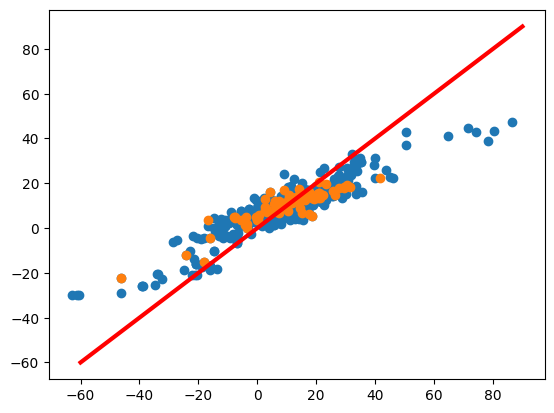

In [60]:
from matplotlib import pyplot as plt

plt.scatter(y_train_all, clf.predict(v_train_all), marker='o')
plt.scatter(y_test_all, clf.predict(v_test_all), marker='o')

#plt.scatter(y_train, clf.predict(X_train), marker='o')

plt.plot([-60, 90], [-60, 90], c='red', lw=3)

In [61]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(y_test_all, clf.predict(v_test_all)))
print(mean_absolute_error(y_test_all,clf.predict(v_test_all)))

0.6751232834030598
6.1764087481292105


In [62]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(y_OCO_test, clf.predict(vector_OCO_test)))
print(mean_absolute_error(y_OCO_test,clf.predict(vector_OCO_test)))

0.7833446539561392
4.054823379144073


In [63]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(y_CLF_test, clf.predict(vector_CLF_test)))
print(mean_absolute_error(y_CLF_test,clf.predict(vector_CLF_test)))

0.5951401817299775
7.564165314466657


In [64]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(y_HD_test, clf.predict(vector_HD_test)))
print(mean_absolute_error(y_HD_test,clf.predict(vector_HD_test)))

0.6393296302870012
6.8316603148885635


In [65]:
#vector_OCO_test, vector_HD_test, vector_CLF_test

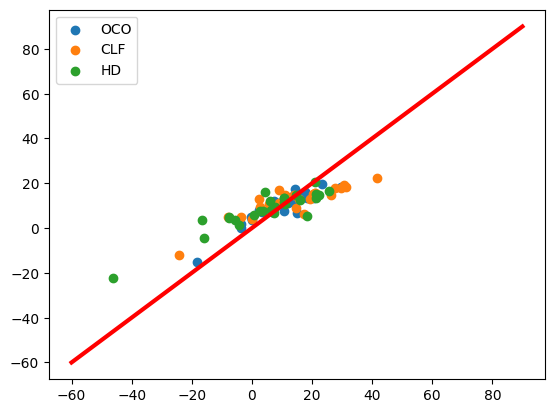

In [66]:
plt.scatter(y_OCO_test, clf.predict(vector_OCO_test), marker='o', label='OCO')
plt.scatter(y_CLF_test, clf.predict(vector_CLF_test), marker='o', label='CLF')
plt.scatter(y_HD_test, clf.predict(vector_HD_test), marker='o', label='HD')

#plt.scatter(y_train, clf.predict(X_train), marker='o')

plt.plot([-60, 90], [-60, 90], c='red', lw=3)
plt.legend()

In [67]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score    

def objective(trial):
    # Define the hyperparameters to be tuned
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 50)

    MF = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    
    
    
    # Initialize the model with the suggested hyperparameters
    model = RandomForestRegressor(n_estimators=n_estimators, 
                                   max_depth=max_depth, 
                                   max_features=MF,
                                   min_samples_split=min_samples_split)

    # Evaluate the model using cross-validation
    score_mea = cross_val_score(model, v_val_all, y_val_all, cv=5, scoring='neg_mean_absolute_error').mean()
    score_r2 = cross_val_score(model, v_val_all, y_val_all, cv=5, scoring='r2').mean()
    score = -score_mea + 10*(1-score_r2)
    score = score_r2
    score = score_mea
    return score

# Create the study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Best parameters
settings = study.best_params
print(settings)

[I 2024-12-08 09:36:43,229] A new study created in memory with name: no-name-1606ea80-50e7-484c-b7d6-f7716e425264
[I 2024-12-08 09:36:43,807] Trial 0 finished with value: -11.098286875919523 and parameters: {'n_estimators': 121, 'max_depth': 37, 'min_samples_split': 41, 'max_features': 'sqrt'}. Best is trial 0 with value: -11.098286875919523.
[I 2024-12-08 09:36:44,622] Trial 1 finished with value: -12.117966283443257 and parameters: {'n_estimators': 175, 'max_depth': 24, 'min_samples_split': 44, 'max_features': 'sqrt'}. Best is trial 0 with value: -11.098286875919523.
[I 2024-12-08 09:36:45,828] Trial 2 finished with value: -6.454056239204327 and parameters: {'n_estimators': 246, 'max_depth': 33, 'min_samples_split': 8, 'max_features': 'sqrt'}. Best is trial 2 with value: -6.454056239204327.
[I 2024-12-08 09:36:46,530] Trial 3 finished with value: -7.490490658718793 and parameters: {'n_estimators': 145, 'max_depth': 37, 'min_samples_split': 12, 'max_features': 'log2'}. Best is trial 2

{'n_estimators': 70, 'max_depth': 45, 'min_samples_split': 4, 'max_features': 'sqrt'}


In [68]:
clf = RandomForestRegressor(**settings)
clf.fit( v_train_all, y_train_all)

RandomForestRegressor(max_depth=45, max_features='sqrt', min_samples_split=4,
                      n_estimators=70)

In [69]:
from sklearn.metrics import r2_score, mean_absolute_error
print(r2_score(y_test_all, clf.predict(v_test_all)))
print(mean_absolute_error(y_test_all,clf.predict(v_test_all)))

0.9155847006208966
2.79570334575002


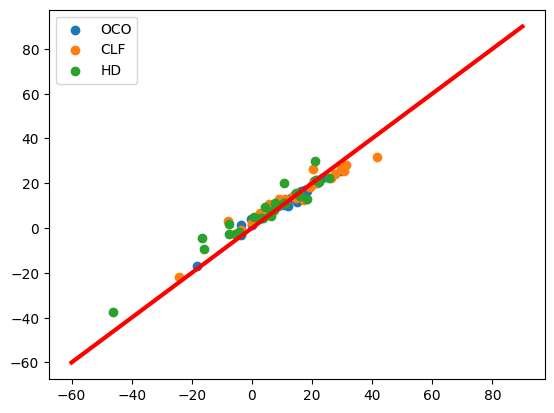

In [70]:
plt.scatter(y_OCO_test, clf.predict(vector_OCO_test), marker='o', label='OCO')
plt.scatter(y_CLF_test, clf.predict(vector_CLF_test), marker='o', label='CLF')
plt.scatter(y_HD_test, clf.predict(vector_HD_test), marker='o', label='HD')

#plt.scatter(y_train, clf.predict(X_train), marker='o')

plt.plot([-60, 90], [-60, 90], c='red', lw=3)
plt.legend()

In [71]:
from sklearn.metrics import r2_score, mean_absolute_error
import optuna
y_pred = clf.predict(v_val_all)

def objective(trial):
    # Define the hyperparameters to be tuned
    a = trial.suggest_float('a', -4, 4)
    b = trial.suggest_float('b', -2, 2)

    def correction(x, a, b):
        return x+a*x+b    
    y_corrected = correction(y_pred, a, b)
    
    score = mean_absolute_error(y_val_all, y_corrected)+5*(1-r2_score(y_val_all, y_corrected))
    #score = 1-r2_score(y_val_all, y_corrected)
    return score

# Create the study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Best parameters
params = study.best_params

[I 2024-12-08 09:38:38,997] A new study created in memory with name: no-name-23b0beb0-f89d-49ca-8881-a39ba1dbb825
[I 2024-12-08 09:38:38,999] Trial 0 finished with value: 4.065775965609665 and parameters: {'a': 0.20873207631945334, 'b': 0.30983479453329954}. Best is trial 0 with value: 4.065775965609665.
[I 2024-12-08 09:38:39,000] Trial 1 finished with value: 12.50795378889076 and parameters: {'a': 0.5891289882773592, 'b': 1.266427879199766}. Best is trial 0 with value: 4.065775965609665.
[I 2024-12-08 09:38:39,000] Trial 2 finished with value: 91.53296838900431 and parameters: {'a': 2.7074546392022887, 'b': 0.07967872387144759}. Best is trial 0 with value: 4.065775965609665.
[I 2024-12-08 09:38:39,001] Trial 3 finished with value: 58.37544535515564 and parameters: {'a': -1.8761059843549805, 'b': -1.6527970364952478}. Best is trial 0 with value: 4.065775965609665.
[I 2024-12-08 09:38:39,002] Trial 4 finished with value: 68.11900089653236 and parameters: {'a': -2.2097722474826567, 'b':

In [79]:
#params={'a': 1.134997891196554, 'b': -1.6173264505748035}

def correction(x, a, b):
        return x+a*x+b

evaluation = {'MEA':{}, 'R2':{}}

for label, test, y in zip(['OCO', 'CLF', 'HD', 'all'], 
                           [vector_OCO_test, vector_CLF_test, vector_HD_test, v_test_all],
                           [y_OCO_test, y_CLF_test, y_HD_test, y_test_all]):
    mea = mean_absolute_error(y,correction(clf.predict(test), **params)) 
    r2= r2_score(y, correction(clf.predict(test), **params))
    evaluation['MEA'][label]=round(mea,2)
    evaluation['R2'][label]=round(r2,2)

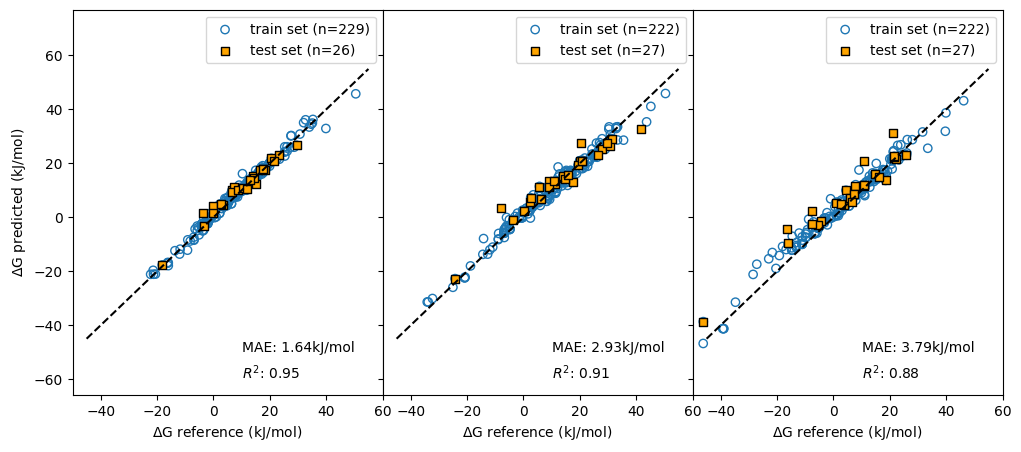

In [80]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, gridspec_kw={'wspace': 0}, figsize=(12, 5))

ntrain_OCO=vector_OCO_train.shape[0]
ntest_OCO=vector_OCO_test.shape[0]

ax1.scatter(y_OCO_train, correction(clf.predict(vector_OCO_train),  **params), 
            marker='o', facecolors='none', edgecolors='tab:blue', label=f"train set (n={ntrain_OCO})")
#ax1.scatter(y_OCO_train, clf.predict(vector_OCO_train), 
#            marker='o', facecolors='none', edgecolors='tab:green', label=f"train set (n={ntrain_OCO})")

ax1.scatter(y_OCO_test, correction(clf.predict(vector_OCO_test),  **params), 
            marker='s',facecolors='orange', edgecolors='black', label=f"test set (n={ntest_OCO})")
ax1.text(10, -50, s="MAE: " + str(evaluation['MEA']['OCO']) +"kJ/mol")
ax1.text(10, -60, s="$R^2$: " + str(evaluation['R2']['OCO']))

ax1.set_xlim(-50, 60)

ntrain_CLF=vector_CLF_tain.shape[0]
ntest_CLF=vector_CLF_test.shape[0]
ax2.scatter(y_CLF_train, correction(clf.predict(vector_CLF_tain),  **params), 
            marker='o', facecolors='none', edgecolors='tab:blue', label=f"train set (n={ntrain_CLF})")
ax2.scatter(y_CLF_test, correction(clf.predict(vector_CLF_test),  **params), 
            marker='s', facecolors='orange', edgecolors='black', label=f"test set (n={ntest_CLF})")
ax2.text(10, -50, s="MAE: " + str(evaluation['MEA']['CLF']) +"kJ/mol")
ax2.text(10, -60, s="$R^2$: " + str(evaluation['R2']['CLF']))

ax2.set_xlim(-50, 60)
ntrain_HD=vector_HD_train.shape[0]
ntest_HD=vector_HD_test.shape[0]
ax3.scatter(y_HD_train, correction(clf.predict(vector_HD_train),  **params), 
            marker='o', facecolors='none', edgecolors='tab:blue', label=f"train set (n={ntrain_HD})")
ax3.scatter(y_HD_test, correction(clf.predict(vector_HD_test),  **params), 
            marker='s',facecolors='orange',  edgecolors='black', label=f"test set (n={ntest_HD})")
ax3.text(10, -50, s="MAE: " + str(evaluation['MEA']['HD']) +"kJ/mol")
ax3.text(10, -60, s="$R^2$: " + str(evaluation['R2']['HD']))

ax3.set_xlim(-50, 60)

for ax in [ax1, ax2, ax3]:
    ax.plot([-45 , 55], [-45, 55], c='black', ls='--')

ax1.set(xlabel='$\Delta$G reference (kJ/mol)', ylabel='$\Delta$G predicted (kJ/mol)')
ax2.set(xlabel='$\Delta$G reference (kJ/mol)')
ax3.set(xlabel='$\Delta$G reference (kJ/mol)')
ax1.legend()
ax2.legend()
ax3.legend()
plt.savefig('RF_results.png', dpi=300)

In [74]:
import numpy as np
ckpt_path = '../exported_ckpts/new-split-paper'
gnn_data_test=dict(np.load(f"{ckpt_path}/test_set/test_results.npz"))
gnn_data_train=dict(np.load(f"{ckpt_path}/train_set/test_results.npz"))

In [75]:
for key in gnn_data_test.keys():
    print(key)

print(gnn_data_train['target-CLF'].shape)

target-OCO
target-HD
target-CLF
target-OCO-1
target-HD-1
target-CLF-1
prediction-OCO
prediction-HD
prediction-CLF
prediction-OCO-1
prediction-HD-1
prediction-CLF-1
(232,)


In [76]:
from sklearn.metrics import r2_score, mean_absolute_error
evaluation = {'MEA':{}, 'R2':{}}

for label in ['OCO', 'CLF', 'HD']:
    print()
    gnn_data_test['prediction-'+label] = gnn_data_test['prediction-'+label][~np.isnan(gnn_data_test['target-'+label])]
    gnn_data_test['target-'+label] = gnn_data_test['target-'+label][~np.isnan(gnn_data_test['target-'+label])]

    gnn_data_train['prediction-'+label] = gnn_data_train['prediction-'+label][~np.isnan(gnn_data_train['target-'+label])]
    gnn_data_train['target-'+label] = gnn_data_train['target-'+label][~np.isnan(gnn_data_train['target-'+label])]
    
    ypred = gnn_data_test['prediction-'+label]
    y = gnn_data_test['target-'+label]



    
    mea = mean_absolute_error(y, ypred) 
    r2= r2_score(y, ypred)
    evaluation['MEA'][label]=round(mea,2)
    evaluation['R2'][label]=round(r2,2)

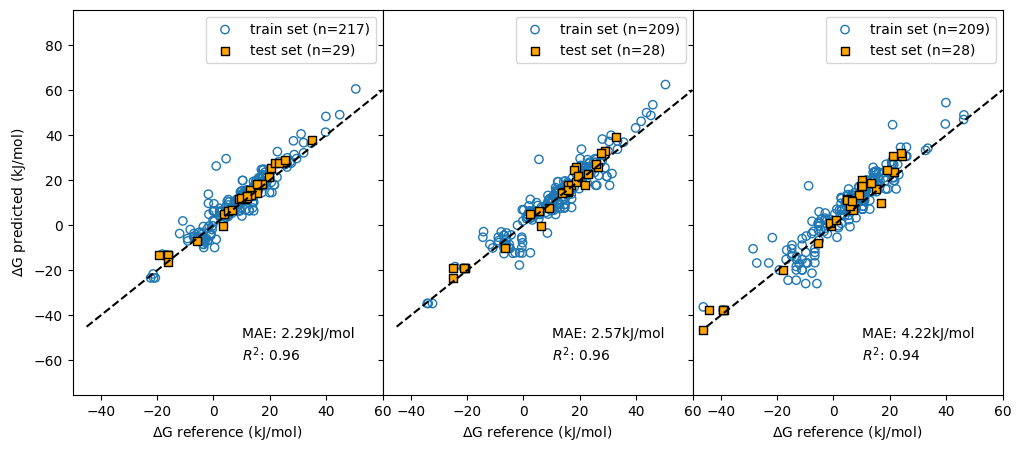

In [77]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, gridspec_kw={'wspace': 0}, figsize=(12, 5))

ntrain_OCO=gnn_data_train['target-OCO'].shape[0]
ntest_OCO=gnn_data_test['target-OCO'].shape[0]

ax1.scatter(gnn_data_train['target-OCO'], gnn_data_train['prediction-OCO'], 
            marker='o', facecolors='none', edgecolors='tab:blue', label=f"train set (n={ntrain_OCO})")
ax1.scatter(gnn_data_test['target-OCO'], gnn_data_test['prediction-OCO'],
            marker='s', facecolors='orange', edgecolors='black', label=f"test set (n={ntest_OCO})")
ax1.text(10, -50, s="MAE: " + str(evaluation['MEA']['OCO']) +"kJ/mol")
ax1.text(10, -60, s="$R^2$: " + str(evaluation['R2']['OCO']))

ax1.set_xlim(-50, 60)

ntrain_CLF=gnn_data_train['target-CLF'].shape[0]
ntest_CLF=gnn_data_test['target-CLF'].shape[0]
ax2.scatter(gnn_data_train['target-CLF'], gnn_data_train['prediction-CLF'], 
            marker='o', facecolors='none', edgecolors='tab:blue', label=f"train set (n={ntrain_CLF})")
ax2.scatter(gnn_data_test['target-CLF'], gnn_data_test['prediction-CLF'],
            marker='s', facecolors='orange', edgecolors='black', label=f"test set (n={ntest_CLF})")
ax2.text(10, -50, s="MAE: " + str(evaluation['MEA']['CLF']) +"kJ/mol")
ax2.text(10, -60, s="$R^2$: " + str(evaluation['R2']['CLF']))

ax2.set_xlim(-50, 60)
ntrain_HD=gnn_data_train['target-HD'].shape[0]
ntest_HD=gnn_data_test['target-HD'].shape[0]
ax3.scatter(gnn_data_train['target-HD'], gnn_data_train['prediction-HD'], 
            marker='o', facecolors='none', edgecolors='tab:blue', label=f"train set (n={ntrain_HD})")
ax3.scatter(gnn_data_test['target-HD'], gnn_data_test['prediction-HD'], 
            marker='s', facecolors='orange', edgecolors='black', label=f"test set (n={ntest_HD})")
ax3.text(10, -50, s="MAE: " + str(evaluation['MEA']['HD']) +"kJ/mol")
ax3.text(10, -60, s="$R^2$: " + str(evaluation['R2']['HD']))

ax3.set_xlim(-50, 60)
ax1.set(xlabel='$\Delta$G reference (kJ/mol)', ylabel='$\Delta$G predicted (kJ/mol)')
ax2.set(xlabel='$\Delta$G reference (kJ/mol)')
ax3.set(xlabel='$\Delta$G reference (kJ/mol)')
ax1.legend()
ax2.legend()
ax3.legend()
for ax in [ax1, ax2, ax3]:
    ax.plot([-45 , 60], [-45, 60], c='black', ls='--')
plt.savefig('GNN_results.png', dpi=300)

In [78]:
gnn_data_train['target-CLF'].shape


(209,)